# Clustering Yelp Restaurants

**Part 1: To be completed INDIVIDUALLY and due on October 13 at 5pm.**

In this assignment, we will be working with the [Yelp dataset](https://www.yelp.com/dataset/challenge). Download the data from Round 10. You can find the format of the dataset [here](https://www.yelp.com/dataset/documentation/json).

From the Business Objects, let's try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" to cluster for similarity. You may want to use only a subset (15-20) of popular categories.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Hi Sophia, there are many overlaps between problem 1 and problem 2. The coding of three techniques is primarily in problem 2 whereas data preprossing, and determination of certain paramters are shown in problem 1

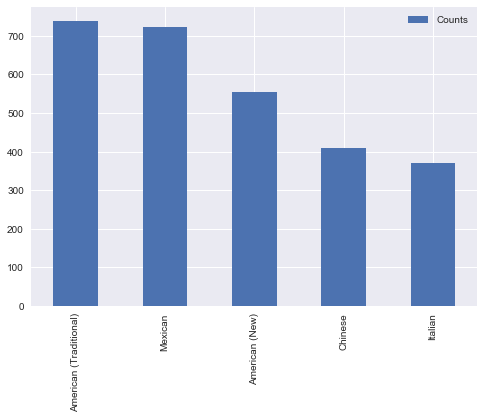

In [3]:
import json
import pprint 
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

data = []
with open('business.json') as f:
    for line in f:
        data.append(json.loads(line))
data = [items for items in data if items['city'] == 'Las Vegas']

cat_list_original= [items['categories'] for items in data]
cat_list = list(itertools.chain(*cat_list_original))
cat_dict = Counter(cat_list)
tag_50 = cat_dict.most_common(50)
tag_50_list = [items[0] for items in tag_50]

I = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
     22,23,24,25,26,27,29,30,31,32,33,34,35,36,37,39,40,
     41,42,43,44,45,47,48,49]
# The following is my 
tag_final = np.delete(tag_50_list, I).tolist()
#['American (Traditional)','Mexican','American (New)','Chinese','Italian']


new_data = [] 
for items in cat_list_original:
    vet_data = [0] * len(tag_final)   # [0,0,0,0,0]
    for ele in range(len(tag_final)):
        if tag_final[ele] in items:
            vet_data[ele] = 1
    new_data.append(vet_data)
new_data = pd.DataFrame(new_data, columns = ['American (Traditional)','Mexican','American (New)','Chinese','Italian'])

data_lat = [items['latitude'] for items in data]
data_lon = [items['longitude'] for items in data]
df = pd.DataFrame(data_lat,columns = ['latitude'])
df.insert(1,'longitude',data_lon)
new_df = pd.concat([df,new_data], axis=1)

k = pd.DataFrame(np.sum(new_data, axis = 0))
k.columns = ['Counts']
k.plot(x = k.index, kind = 'bar')
plt.show()

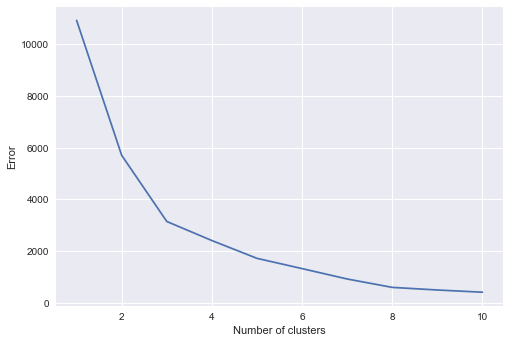

In [23]:
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')
    plt.show()
    
evaluate_clusters(new_df,10)
# Although the elbow method shows that 3 clusters is a good estimate to begin with, I will 
# 5 clusters for my k-means algorithm

Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned. **(10 pts)**

Note that some categories are inherently more common (e.g. "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

In [ ]:
'''
This is the weight balancing part. I tried many different combinations of weights 
but none of them give me a better clustering outcome 

new_df['American (Traditional)'] = new_df['American (Traditional)'].apply(lambda x: 0.6 * x)
new_df['Mexican'] = new_df['Mexican'].apply(lambda x: 0.6 * x)
new_df['Italian'] = new_df['Italian'].apply(lambda x: 30 * x)
'''

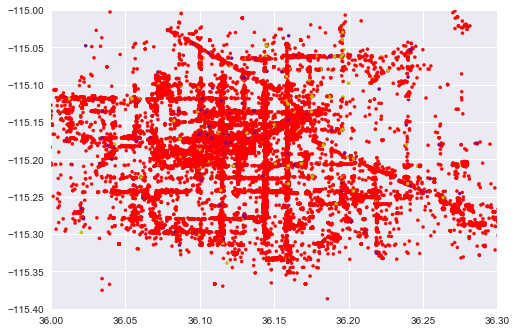

In [4]:
# K-means 
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
assign = kmeans.fit_predict(new_df)

LABEL_COLOR_MAP = {0 : 'r', 1 : 'k', 2 : 'b', 3 : 'purple', 4 : 'y'}
label_color = [LABEL_COLOR_MAP[l] for l in assign]
plt.scatter(new_df.iloc[:,0],new_df.iloc[:,1], s = 10, c = label_color, marker = 'o')
plt.xlim(36, 36.3)
plt.ylim(-115.4,-115)
plt.show()

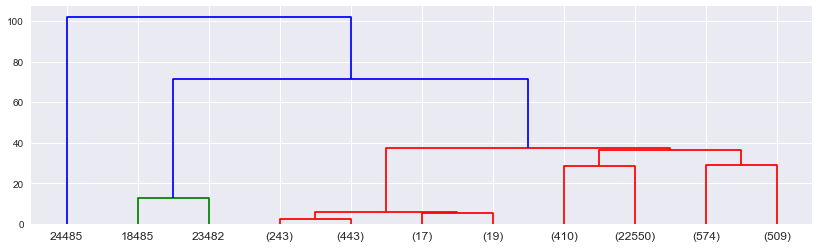

In [33]:
# Hierarchical
import scipy.cluster.hierarchy as hierarchy
Z_20ng = hierarchy.linkage(new_df, method='ward', metric='euclidean')
plt.figure(figsize=(14,4))
R_20ng = hierarchy.dendrogram(Z_20ng, p=4, truncate_mode='level', show_leaf_counts=True)
plt.show()

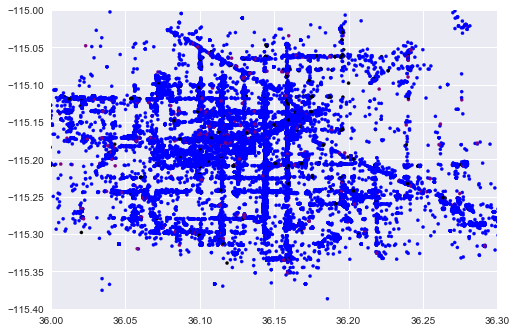

In [37]:
clusters = hierarchy.fcluster(Z_20ng, 5, criterion='maxclust')
LABEL_COLOR_MAP_hi = {1 : 'r', 2 : 'k', 3 : 'b', 4 : 'purple', 5 : 'y'}
label_color_hi = [LABEL_COLOR_MAP_hi[l] for l in clusters]
plt.scatter(new_df.iloc[:,0],new_df.iloc[:,1], s = 10, c = label_color_hi, marker = 'o')
plt.xlim(36, 36.3)
plt.ylim(-115.4,-115)
plt.show()

/Users/CJ/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/CJ/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/CJ/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/CJ/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: Deprecat

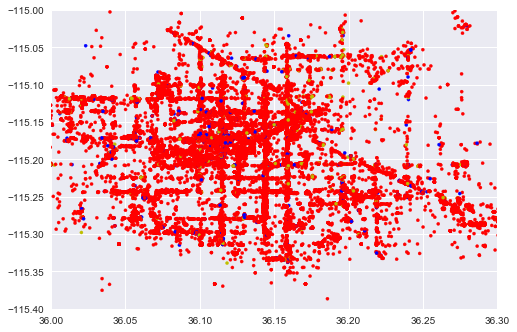

In [38]:
# GMM
gmm = mixture.GMM(n_components=5, covariance_type='full')
gmm.fit(new_df)
y_pred = gmm.predict(new_df)
label_color_GMM = [LABEL_COLOR_MAP[p] for p in y_pred]
plt.scatter(new_df.iloc[:,0],new_df.iloc[:,1], s = 10, c = label_color_GMM, marker = 'o')
plt.xlim(36, 36.3)
plt.ylim(-115.4,-115)
plt.show()

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

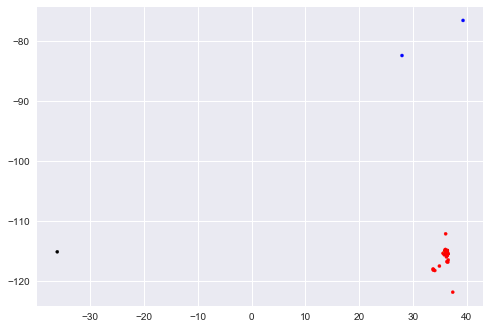

[   {   'address': '',
        'attributes': {'GoodForKids': True},
        'business_id': 'QWzFfBA7vDI0hyBnGT4x4g',
        'categories': ['Performing Arts', 'Arts & Entertainment'],
        'city': 'Las Vegas',
        'hours': {},
        'is_open': 1,
        'latitude': 39.2885345762,
        'longitude': -76.6187281267,
        'name': 'Cirque du Soleil - TORUK - The First Flight',
        'neighborhood': 'Downtown',
        'postal_code': '89101',
        'review_count': 71,
        'stars': 1.5,
        'state': 'NV'},
    {   'address': '7135 Gilespie St',
        'attributes': {},
        'business_id': 'pYeoaUJ6veQ3FEiSBnVMcw',
        'categories': ['Car Rental', 'Hotels & Travel'],
        'city': 'Las Vegas',
        'hours': {   'Friday': '0:00-0:00',
                     'Monday': '0:00-0:00',
                     'Saturday': '0:00-0:00',
                     'Sunday': '0:00-0:00',
                     'Thursday': '0:00-0:00',
                     'Tuesday': '0:00-0:00'

In [36]:
plt.scatter(new_df.iloc[:,0],new_df.iloc[:,1], s = 10, c = label_color, marker = 'o')
plt.show()

outliers = [items for items in data if items['latitude'] < -30 or items['longitude'] > -90]
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(outliers)

As we can see if we don't put xlim and ylim, most of points will just cluster in lower right region,causing practitioners to think they plot fewers coordinates than it should be. However, bad leverage points should bear more blame than us. The existence of utliers in the lower left and upper right corners skew the graph badly. Their coordinates are so extreme that fewer points seem to be illustrated. I believe the single dot in the lower left corner is mistaken due to a human error(incorrect input)as latitude should be postive and strictly between [30,40] if in Las Vegas areas. Outliers in the upper right corners are mistaken due to the fact that there is another city in FL also named "Las Vegas". We need to take into account that just filtering out business objects whose location are in "Las Vegas" will not guarantee us to get something we intended to search. If we delete these outliers and put limits on each axis, a more justifiable plot will be generated as I have shown above.

Give a detailed analysis comparing the results you obtained from the 3 techniques. **(10 pts)**

The k-means algorithm is parameterized by the value k, which is the number of clusters that I want to create. The algorithm begins by creating k centroids (In my case, k = 5). It then iterates between an assign step (where each sample is assigned to its closest centroid) and an update step (where each centroid is updated to become the mean of all the samples that are assigned to it. This iteration continues until some stopping criteria is met; for example, if no sample is re-assigned to a different centroid. The k-means algorithm makes a number of assumptions about the data while the most notable assumption is that the data is 'spherical'. 

Agglomerative hierarchical clustering(Bottom up), instead, builds clusters incrementally, producing a dendogram as I have illustrated above. The algorithm begins by assigning each sample to its own cluster at lowest level. At each step, the two clusters that 
are the most similar are merged; The are many different metrics for measuing distance / similarity, and the method that I used to meansure distance is "Ward". The algorithm continues until all of the clusters have been merged. Unlike k-means, I don't need to specify
a k parameter. 

Unlike k-means where Every object is assigned to a single cluster, GMM use probability to capture our uncertainty about the cluster that any single individual belongs as we believe that the best description of the data is a set of overlapping clusters. We consider each cluster follows the Gaussian(normal) distrubution. As we implement Expectation Maximization Algorithm with the Gaussian Model, we can as well the P(Cj|xi), that is, the probability that each point is a member of each cluster. In general EM is a versatile algorithm that can be used in many other settings

Although I get similar results using three different techniques, the result may not be the same in other senarios. All three techniques require me to enter a pre-defined number of clusters/ components. We can graph error, Adjusted Rand Index, or Silhouette Coefficient based on the number of clusters. The first technique we simply apply elbow method whereas the latter ones we want them to get closed to 1. Moreover, hierarchy.fcluster can be very computationally expensive when dataset gets large, and therefore I personally prefer K-means ++ and GMM to hierarchical clustering. 